# Exploratory Data Analysis (EDA)

The goal of this exploratory data analysis is to examine the extent to which there are differences between audio recordings from urban and natural environments across (1) soundscape indices, (2) spectrotemporal modulation power, and (3) embeddings generated by pre-trained audio CNN models.

# Load data

In [1]:
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import random as python_random

import pickle
import pandas as pd
import numpy as np
import glob

In [2]:
df_all = pd.read_csv('../train_val_test_split/train_val_test_GoogleAudioSet.csv', index_col=0)

embedding_raw_matrix = np.load('../data/processed/20230304/embedding_raw_matrix.npy')
embedding_bg_matrix = np.load('../data/processed/20230304/embedding_bg_matrix.npy')
embedding_fg_matrix = np.load('../data/processed/20230304/embedding_fg_matrix.npy')

vgg_raw_matrix = np.load('../data/processed/20230304/vgg_raw_matrix.npy')
vgg_bg_matrix = np.load('../data/processed/20230304/vgg_bg_matrix.npy')
vgg_fg_matrix = np.load('../data/processed/20230304/vgg_fg_matrix.npy')

mps_raw_matrix = np.load('../data/processed/20230304/mps_raw_matrix.npy')
mps_bg_matrix = np.load('../data/processed/20230304/mps_bg_matrix.npy')
mps_fg_matrix = np.load('../data/processed/20230304/mps_fg_matrix.npy')

df_indices_raw = pd.read_csv('../data/processed/20230304/df_indices_raw.csv', index_col=0)
df_indices_bg = pd.read_csv('../data/processed/20230304/df_indices_bg.csv', index_col=0)
df_indices_fg = pd.read_csv('../data/processed/20230304/df_indices_fg.csv', index_col=0)


panns_embedding_raw = np.load('../data/processed/20230304/panns_embedding_raw.npy')
panns_embedding_bg = np.load('../data/processed/20230304/panns_embedding_bg.npy')
panns_embedding_fg = np.load('../data/processed/20230304/panns_embedding_fg.npy')

In [3]:
ind_city = df_all['category'] == 1
ind_nature = df_all['category'] == 0

# T-test of "city vs. nature": soundscape indices

In [4]:
from scipy.stats import ttest_ind

statistic_all, pvalue_all = ttest_ind(df_indices_raw[ind_nature], df_indices_raw[ind_city], nan_policy='omit', equal_var=False)
statistic_bg, pvalue_bg = ttest_ind(df_indices_bg[ind_nature], df_indices_bg[ind_city], nan_policy='omit', equal_var=False)
statistic_fg, pvalue_fg = ttest_ind(df_indices_fg[ind_nature], df_indices_fg[ind_city], nan_policy='omit', equal_var=False)

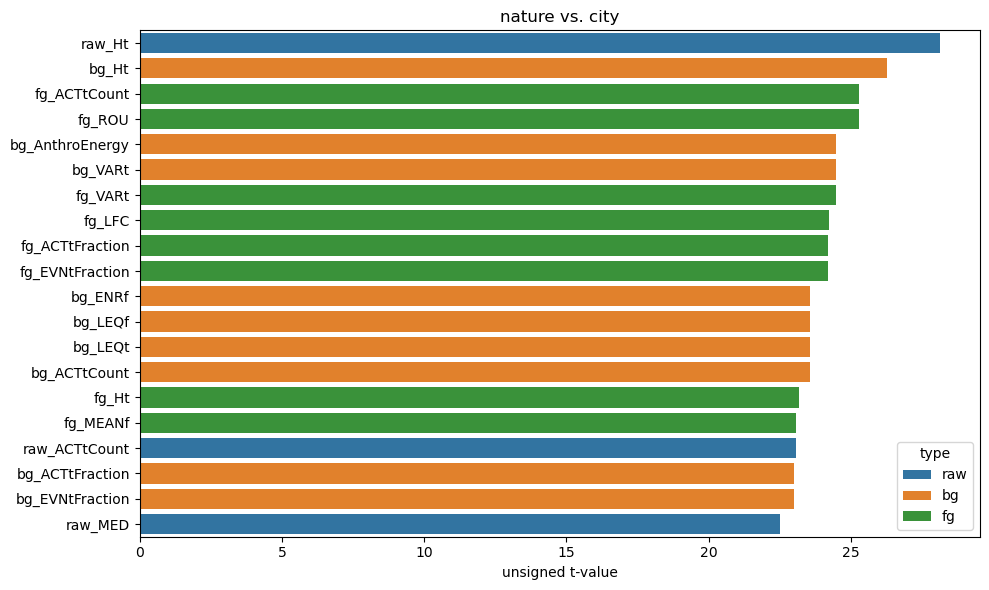

In [5]:
tval_df = pd.DataFrame(index = ('raw_'+df_indices_raw.columns).append('bg_'+df_indices_bg.columns).append('fg_'+df_indices_fg.columns), 
                       data = np.abs(list(statistic_all.data)+list(statistic_bg.data)+list(statistic_fg.data)),
                       columns = ['stats'])
tval_df['type'] = [i.split('_', 1)[0] for i in tval_df.index]

tval_df.sort_values(by=['stats'], ascending=False, inplace = True)
sel_range = 20
tval_df = tval_df.iloc[:sel_range]

fig, ax = plt.subplots(figsize=(10,6)) 

graph = sns.barplot(y=list(tval_df.index), x=tval_df['stats'], ax=ax, orient = 'h', hue=tval_df['type'], dodge = False)
ax.set_xlabel('unsigned t-value')
plt.title('nature vs. city')
plt.tight_layout()
plt.show()

Of the top 20 indices with the largest unsigned t-values, 9 were based on background (bg) signal, 8 were based on foreground signal, and 3 were based on raw signal (the mixture of bg and fg). Moreover, the indices that showed the greatest differences between urban and natural categories varied across signals. This suggests that the separation of bg and fg signals is effective and that both types of signal contain valuable information for classification.

# Correlations among indices

Using linear correlation to inspect whether there are any associations among the indices.

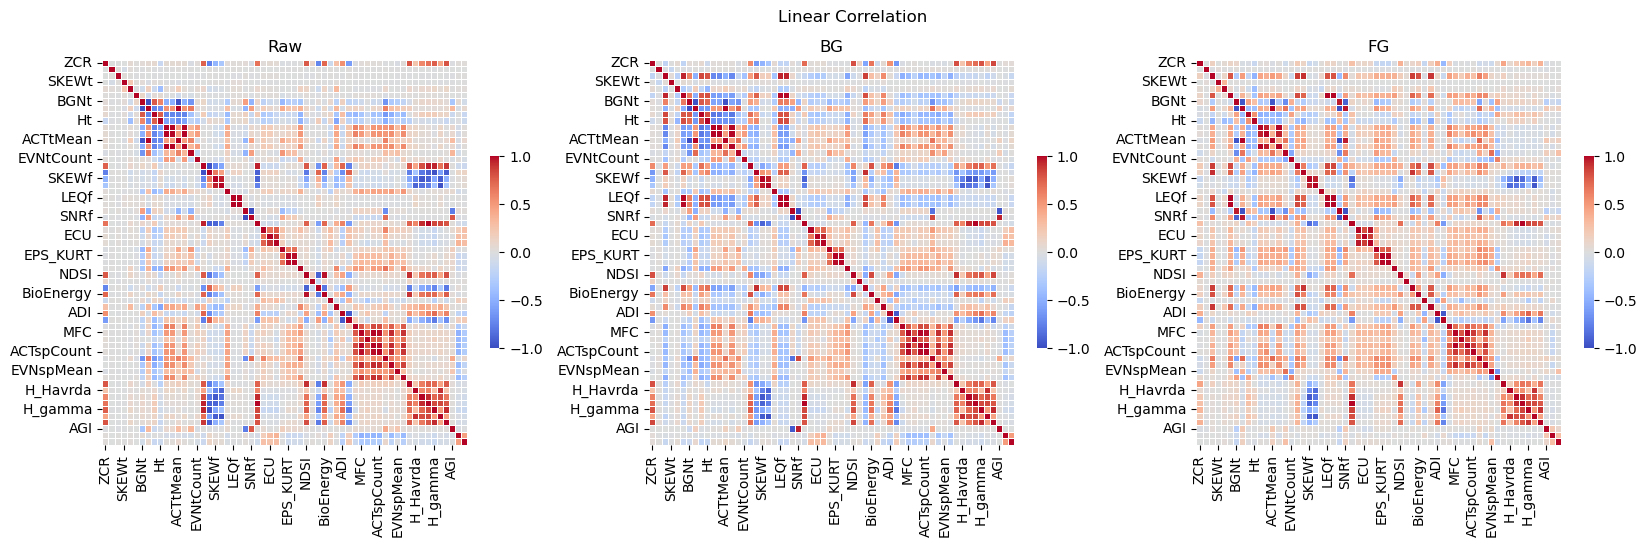

In [6]:
fig, (ax1, ax2, ax3)  = plt.subplots(ncols=3, figsize=(20,5)) 
sns.heatmap(df_indices_raw.corr(), linewidth = 0.5 , cmap = 'coolwarm', vmin=-1, vmax=1, ax = ax1, cbar_kws={"shrink": 0.5})
sns.heatmap(df_indices_bg.corr(), linewidth = 0.5 , cmap = 'coolwarm', vmin=-1, vmax=1, ax = ax2, cbar_kws={"shrink": 0.5})
sns.heatmap(df_indices_fg.corr(), linewidth = 0.5 , cmap = 'coolwarm', vmin=-1, vmax=1, ax = ax3, cbar_kws={"shrink": 0.5})
ax1.title.set_text('Raw')
ax2.title.set_text('BG')
ax3.title.set_text('FG')
plt.suptitle('Linear Correlation')
plt.show()

Obviously, some indices have high correlations. Therefore, the dimensionality of the soundscape indices' data can be significantly reduced before applying deep learning.

# T-test of "city vs. nature": spectrotemporal modulation power

In [7]:
statistic_all, pvalue_all = ttest_ind(mps_raw_matrix[ind_nature,:], mps_raw_matrix[ind_city,:], nan_policy='omit', equal_var=False, axis=0)
statistic_bg, pvalue_bg = ttest_ind(mps_bg_matrix[ind_nature,:], mps_bg_matrix[ind_city,:], nan_policy='omit', equal_var=False, axis=0)
statistic_fg, pvalue_fg = ttest_ind(mps_fg_matrix[ind_nature,:], mps_fg_matrix[ind_city,:], nan_policy='omit', equal_var=False, axis=0)

# reshape back to 2D
statistic_all_reshape = statistic_all.reshape(77,101)
statistic_bg_reshape = statistic_bg.reshape(77,101)
statistic_fg_reshape = statistic_fg.reshape(77,101)

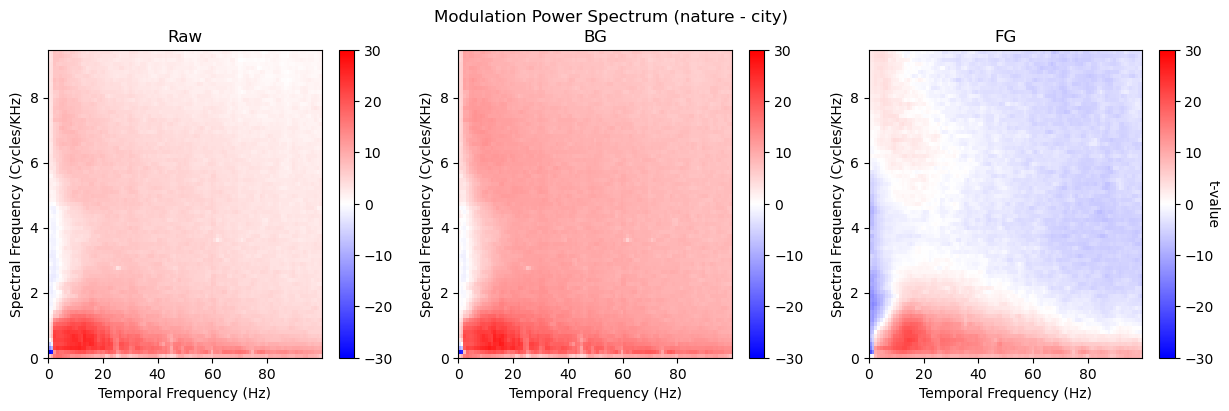

In [8]:
# getting the axis from one file
import pickle
file = open(df_all.loc[0,'file'], 'rb')
output = pickle.load(file)
wt_ind = output['wt']<=100
wt = output['wt'][output['wt']<=100]
wf = output['wf']
file.close()

# plot
fig, (ax1, ax2, ax3)  = plt.subplots(ncols=3, figsize=(15,4)) 
cmap = plt.get_cmap('bwr')
ex = (wt.min(), wt.max(), wf.min()*1e3, wf.max()*1e3)
scale_max = 30
img1 = ax1.imshow(statistic_all_reshape, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex, 
          vmin = -scale_max, vmax = scale_max)
ax1.set_ylabel('Spectral Frequency (Cycles/KHz)')
ax1.set_xlabel('Temporal Frequency (Hz)')
img2 = ax2.imshow(statistic_bg_reshape, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex, 
          vmin = -scale_max, vmax = scale_max)
ax2.set_ylabel('Spectral Frequency (Cycles/KHz)')
ax2.set_xlabel('Temporal Frequency (Hz)')
img3 = ax3.imshow(statistic_fg_reshape, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex, 
          vmin = -scale_max, vmax = scale_max)
ax3.set_ylabel('Spectral Frequency (Cycles/KHz)')
ax3.set_xlabel('Temporal Frequency (Hz)')
fig.colorbar(img1, ax=ax1)
fig.colorbar(img2, ax=ax2)
cbar = fig.colorbar(img3, ax=ax3)
cbar.ax.set_ylabel('t-value', rotation=270)
plt.ylim((0,wf.max()*1e3))
ax1.title.set_text('Raw')
ax2.title.set_text('BG')
ax3.title.set_text('FG')
plt.suptitle('Modulation Power Spectrum (nature - city)')
plt.show()

The heatmaps of t-values reveal that the audio recordings obtained in urban and rural/natural environments exhibit distinct spectrotemporal modulation patterns.
A few noteworthy observations can be made:
- Raw, BG, and FG demonstrate similar but different patterns of significance, indicating that signal segregation is functioning as intended.
- It is evident from the heatmaps that certain clusters exist. Therefore, it may be worthwhile to consider dimensionality reduction prior to applying deep learning techniques.

# Visualizing high-dimensional embeddings using t-distributed stochastic neighbor embedding (t-SNE)

Since each pre-trained CNN model transforms an audio signal into high-dimensional embeddings (VGGish: 128, YAMNet: 1024, PANNs: 2048), it can be challenging to use traditional statistics to evaluate the differences between audio recordings from urban and natural environments. 

However, t-SNE is a useful approach for visualizing high-dimensional data and can provide insight into the separation of the data.

In [9]:
def plot_multiple_tsne(data_raw, data_bg, data_fg, label_in, suptitle):
    from sklearn.manifold import TSNE
    
    tsne_raw = TSNE(n_components=2, verbose=0, perplexity=30, random_state=23, n_jobs=-1)
    tsne_raw_results = tsne_raw.fit_transform(data_raw)
    
    tsne_bg = TSNE(n_components=2, verbose=0, perplexity=30, random_state=23, n_jobs=-1)
    tsne_bg_results = tsne_bg.fit_transform(data_bg)
    
    tsne_fg = TSNE(n_components=2, verbose=0, perplexity=30, random_state=23, n_jobs=-1)
    tsne_fg_results = tsne_fg.fit_transform(data_fg)
    
    label = label_in.copy()
    
    label.replace([0,1], ['nature','city'], inplace = True)
    
    fig, (ax1, ax2, ax3)  = plt.subplots(ncols=3, figsize=(16,4)) 

    sns.scatterplot(
        x=tsne_raw_results[:,0], y=tsne_raw_results[:,1],
        hue=label,
        palette=sns.color_palette("pastel",2),
        legend="full",
        alpha=0.8,
        s=10,
        ax=ax1
    )
    
    sns.scatterplot(
        x=tsne_bg_results[:,0], y=tsne_bg_results[:,1],
        hue=label,
        palette=sns.color_palette("pastel",2),
        legend="full",
        alpha=0.8,
        s=10,
        ax=ax2
    )
    
    sns.scatterplot(
        x=tsne_fg_results[:,0], y=tsne_fg_results[:,1],
        hue=label,
        palette=sns.color_palette("pastel",2),
        legend="full",
        alpha=0.8,
        s=10,
        ax=ax3
    )
    
    
    ax1.set_xlabel('tsne: dim 1')
    ax1.set_ylabel('tsne: dim 2')
    ax2.set_xlabel('tsne: dim 1')
    ax2.set_ylabel('tsne: dim 2')
    ax3.set_xlabel('tsne: dim 1')
    ax3.set_ylabel('tsne: dim 2')
    
    ax1.title.set_text('Raw')
    ax2.title.set_text('BG')
    ax3.title.set_text('FG')
    plt.suptitle(suptitle)
    
    plt.show()

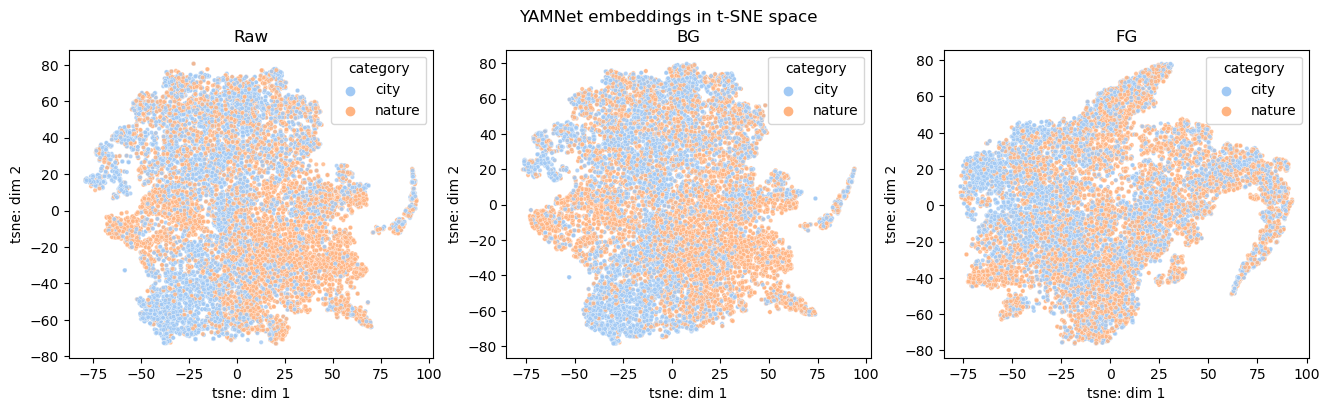

In [10]:
plot_multiple_tsne(embedding_raw_matrix, embedding_bg_matrix, embedding_fg_matrix, df_all['category'], 'YAMNet embeddings in t-SNE space')

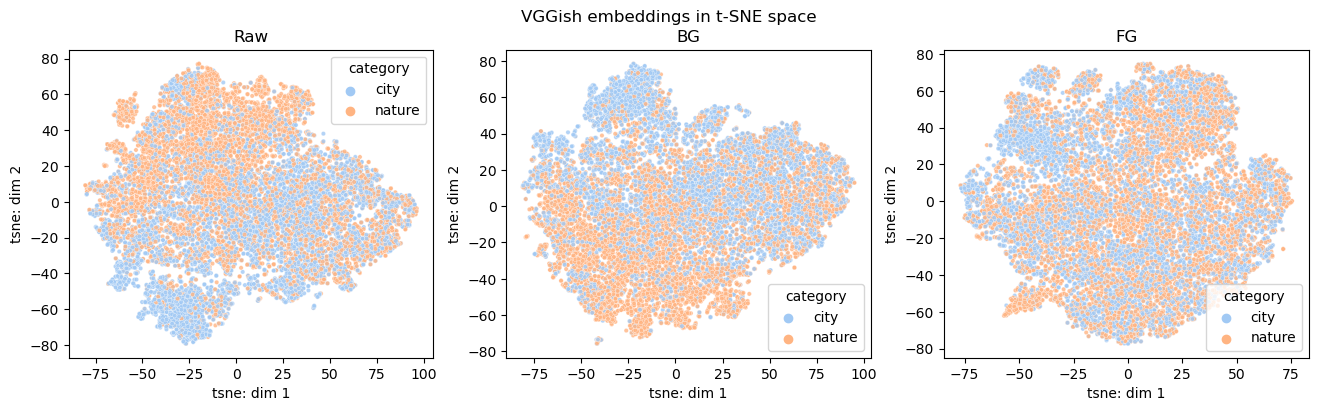

In [11]:
plot_multiple_tsne(vgg_raw_matrix, vgg_bg_matrix, vgg_fg_matrix, df_all['category'], 'VGGish embeddings in t-SNE space')

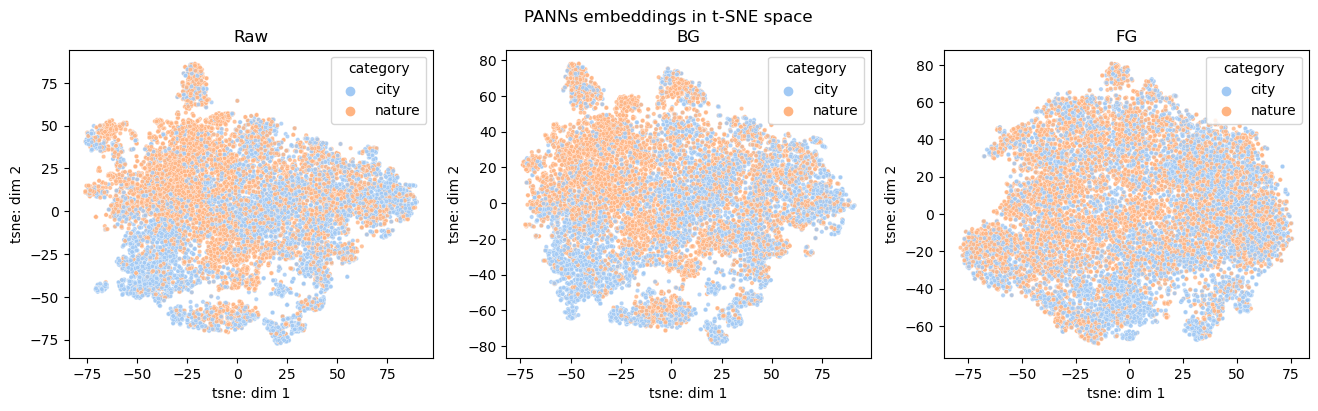

In [12]:
plot_multiple_tsne(panns_embedding_raw, panns_embedding_bg, panns_embedding_fg, df_all['category'], 'PANNs embeddings in t-SNE space')

There was only weak segregation between the two sets of data in t-SNE space. It would require a deep learning model to perform a more effective classification.

# Takeaway

Audio recordings from urban and natural environments exhibit some differences across soundscape indices, spectrotemporal modulation power, and embeddings generated by pre-trained audio CNN models, suggesting that these features hold promise for training a deep learning classifier. However, the large number of features may lead to the "curse of dimensionality". To address this issue, I will use principal component analysis (PCA) to reduce the dimensionality of the data before proceeding with deep learning.